# Baseball Pitching Cluster Analysis (2021 Season)

The goal of this project is to perform cluster analysis using pitching data, to help us identify clusters of similar types of pitchers. Cluster analysis is an unsupervised learning method, which does not have a specified target column. Instead, our goal is to identify pitchers who are similar based on their performance and pitching styles.

For this study, we will perform 2 cluster analyses:
1. Identify similar pitchers based on their performance statistics - Use season statistics such as Earned Runs and Strikes/Walks/Hits per inning.
2. Identify similar pitchers based on their pitching style - Use the % of different types of pitches thrown (e.g.: pitchers who dominantly throw fastballs vs. pitchers who have a lot of variation).

There are several applications for this study in baseball. For example, baseball teams could perform a similar analysis to help them identify potential players to scout. From a purely analytical perspective, this study can also help identify unknown/undervalued prospects whose performance might be similar to more established pitchers.

In [1]:
# pip install pybaseball
# pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import pitching_stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


pd.set_option('display.max_columns', None)

## Data Collection

In [3]:
# We will limit this analysis to data obtained between 2021 and 2022. However, the study can easily be extended by considering more seasons
data = pitching_stats(2021,2022) 
print(data.shape)
data.head()

(84, 393)


,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,BUH,K/9,BB/9,K/BB,H/9,HR/9,AVG,WHIP,BABIP,LOB%,FIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,Starting,Start-IP,Relieving,Relief-IP,RAR,Dollars,tERA,xFIP,WPA,-WPA,+WPA,RE24,REW,pLI,inLI,gmLI,exLI,Pulls,WPA/LI,Clutch,FB% 2,FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,HLD,SD,MD,ERA-,FIP-,xFIP-,K%,BB%,SIERA,RS/9,E-F,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,RA9-WAR,BIP-Wins,LOB-Wins,FDP-Wins,Age Rng,K-BB%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,kwERA,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,K/9+,BB/9+,K/BB+,H/9+,HR/9+,AVG+,WHIP+,BABIP+,LOB%+,K%+,BB%+,LD%+,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xERA,botERA,botOvr CH,botStf CH,botCmd CH,botOvr CU,botStf CU,botCmd CU,botOvr FA,botStf FA,botCmd FA,botOvr SI,botStf SI,botCmd SI,botOvr SL,botStf SL,botCmd SL,botOvr KC,botStf KC,botCmd KC,botOvr FC,botStf FC,botCmd FC,botOvr FS,botStf FS,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
6,19361,2021,Corbin Burnes,MIL,26,11,5,7.5,2.43,28,28,0,0,0,0,167.0,657,123,47,45,7,34,0,6,5,0,234,185,115,79,9,872,1722,2594,85,17,4,1,12.61,1.83,6.88,6.63,0.38,0.199,0.94,0.309,0.757,1.63,1.61,0.208,0.488,0.303,0.078,0.061,0.092,0.250,65.3,167.0,NaN,NaN,65.3,$59.8,1.94,2.30,3.31,-9.18,12.49,34.93,3.55,1.00,0.97,0.87,1.37,28,4.44,-1.13,0.108,96.9,0.090,88.1,0.522,95.3,0.184,81.3,0.098,90.7,NaN,NaN,NaN,NaN,NaN,NaN,-2.4,7.0,24.2,13.3,0.7,NaN,NaN,-0.85,2.99,1.79,2.79,0.27,NaN,NaN,0.378,0.655,0.485,0.489,0.811,0.658,0.389,0.624,0.166,0,0,0,58,38,54,0.356,0.052,2.61,4.58,0.79,0.015,NaN,0.523,NaN,NaN,0.091,0.092,0.183,NaN,NaN,0.096,NaN,NaN,NaN,96.4,NaN,95.2,NaN,NaN,96.9,88.0,81.2,NaN,NaN,90.7,NaN,NaN,-3.4,NaN,2.1,NaN,NaN,-6.9,3.9,6.3,NaN,NaN,-8.0,NaN,NaN,8.2,NaN,6.7,NaN,NaN,7.3,0.3,-4.2,NaN,NaN,4.7,NaN,NaN,-2.3,NaN,26.2,NaN,NaN,-0.4,7.1,14.1,NaN,NaN,0.6,NaN,NaN,-5.68,NaN,1.93,NaN,NaN,-0.16,2.98,2.98,NaN,NaN,0.25,NaN,NaN,0.329,0.645,0.485,0.374,0.806,0.

**Details about the dataset columns and statistics can be found on: https://library.fangraphs.com/pitching/complete-list-pitching/**

In [4]:
#Only consider pitchers who have faced at least 50 batters during the given time period
data = data.loc[data.TBF > 50]

As mentioned previously, we will be performing 2 cluster analysis based on:
1. Pitching performance statistics
2. Pitching style statistics

**Attributes used to Classify Pitchers Based on Performance**:
1. xFIP (Expected Fielding Independent Pitching): An estimate of a pitcher’s ERA based on strikeouts, walks/HBP, and fly balls allowed, assuming league average results on balls in play and home run to fly ball ratio. This potentially gives a more fair comparison of ERA for pitchers across different teams.
2. K/9 - Average number of strikeouts per 9 innings.
3. BB/9 - Average number of walks per 9 innings.
4. H/9 -  Average number of hits allowed per 9 innings.
5. HR/9 - Average number of home runs allowed per 9 innings.
6. K/BB - Ratio of strikeouts to walks.
7. WHIP: Walks plus Hits per Innings Pitched - Number of baserunners a pitcher has allowed per inning pitched. WHIP is calculated by adding the number of walks and hits allowed and dividing this sum by the number of innings pitched.
8. BABIP: Batting Average on Balls in Play - The rate at which the pitcher allows a hit when the ball is put in play, calculated as (H-HR)/(AB-K-HR+SF)

In [5]:
data_performance = data[["Name","xFIP","K/9","BB/9","H/9","HR/9","K/BB","WHIP","AVG","BABIP"]]
data_performance.head()

,Name,xFIP,K/9,BB/9,H/9,HR/9,K/BB,WHIP,AVG,BABIP
6,Corbin Burnes,2.30,12.61,1.83,6.63,0.38,6.88,0.94,0.199,0.309
14,Zack Wheeler,2.84,10.42,1.94,7.13,0.68,5.37,1.01,0.213,0.288
38,Aaron Nola,2.77,10.32,1.27,7.38,0.83,8.10,0.96,0.218,0.289
19,Carlos Rodon,2.91,11.98,2.63,6.62,0.61,4.56,1.03,0.200,0.293
0,Justin Verlander,3.23,9.51,1.49,5.97,0.62,6.38,0.83,0.184,0.240


**Attributed used to Classify Pitchers Based on Pitching Style**:
1. SL% - Slider Percentage	
2. CT% - Cutter Percentage
3. CB% - Curveball Percentage
4. CH% - Changeup Percentage
5. SF% - Split-Finger Percentage
6. KN% - Knuckleball Percentage
9. FB% 2 - Fastball Percentage
10. FBv - Average fastball velocity - included as this is one key attribute that helps differentiate pitchers who rely on the fastball.
11. O-Swing%: Outside the Zone Swing Percentage -  Swings at pitches outside the zone divided by pitches outside the zone - included as it shows the pitcher's ability to make the batter swing at pitches that are outside the zone.

In [6]:
data_style = data[["Name","SL%","CT%","CB%","CH%","SF%","KN%","FB% 2","FBv", "O-Swing%"]]
data_style.head()

,Name,SL%,CT%,CB%,CH%,SF%,KN%,FB% 2,FBv,O-Swing%
6,Corbin Burnes,0.090,0.522,0.184,0.098,NaN,NaN,0.108,96.9,0.378
14,Zack Wheeler,0.249,NaN,0.107,0.032,0.004,NaN,0.607,97.1,0.352
38,Aaron Nola,NaN,0.065,0.265,0.145,NaN,NaN,0.524,92.6,0.370
19,Carlos Rodon,0.310,NaN,0.058,0.020,NaN,NaN,0.612,95.6,0.344
0,Justin Verlander,0.283,NaN,0.188,0.024,NaN,NaN,0.504,95.1,0.369


# Cluster Analysis 1: Pitcher Performance

In [7]:
data_performance = data_performance.set_index("Name")
data_performance.head()

,xFIP,K/9,BB/9,H/9,HR/9,K/BB,WHIP,AVG,BABIP
Name,,,,,,,,,
Corbin Burnes,2.30,12.61,1.83,6.63,0.38,6.88,0.94,0.199,0.309
Zack Wheeler,2.84,10.42,1.94,7.13,0.68,5.37,1.01,0.213,0.288
Aaron Nola,2.77,10.32,1.27,7.38,0.83,8.10,0.96,0.218,0.289
Carlos Rodon,2.91,11.98,2.63,6.62,0.61,4.56,1.03,0.200,0.293
Justin Verlander,3.23,9.51,1.49,5.97,0.62,6.38,0.83,0.184,0.240


In [8]:
#Scale the features since we will be using a distance based algorithm
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_performance)
scaled_performance_df = pd.DataFrame(scaled_data, columns=data_performance.columns, index=data_performance.index)
scaled_performance_df.head()

,xFIP,K/9,BB/9,H/9,HR/9,K/BB,WHIP,AVG,BABIP
Name,,,,,,,,,
Corbin Burnes,0.000000,1.000000,0.222222,0.155022,0.000000,0.812018,0.157143,0.142857,0.597015
Zack Wheeler,0.207692,0.709549,0.258170,0.264192,0.192308,0.579353,0.257143,0.276190,0.440299
Aaron Nola,0.180769,0.696286,0.039216,0.318777,0.288462,1.000000,0.185714,0.323810,0.447761
Carlos Rodon,0.234615,0.916446,0.483660,0.152838,0.147436,0.454545,0.285714,0.152381,0.477612
Justin Verlander,0.357692,0.588859,0.111111,0.010917,0.153846,0.734977,0.000000,0.000000,0.082090


### Identify the appropriate number of clusters

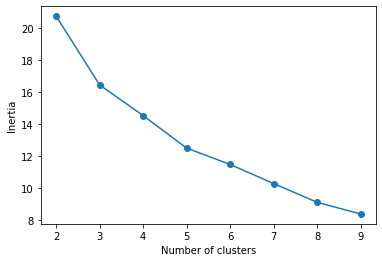

In [9]:
# We will use the Elbow Method to determine the ideal number of clusters for KMeans using the inertia score:
inertia_score = []

for k in range(2, 10):
    model = KMeans(n_clusters = k, random_state = 0)
    model.fit(scaled_performance_df)
    inertia_score.append(model.inertia_)

plt.plot(range(2,10), inertia_score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

From the graph, we see that we can use anywhere between 5 to 7 clusters for our study. I will be using k=5 for the first performance based cluster analysis.

### Create the clusters

In [10]:
# K means using 5 clusters
kmeans_performance = KMeans(n_clusters = 5, init='k-means++', random_state=0)
kmeans_performance.fit(scaled_performance_df)
pred = kmeans_performance.predict(scaled_performance_df)

scaled_performance_df['cluster'] = pred

In [11]:
scaled_performance_df.cluster.value_counts()

3    21
1    21
2    19
0    15
4     8
Name: cluster, dtype: int64

We see that except one of the clusters, all the remaining clusters have ~15 to 20 players within them. We will now evaluate the characteristics of these clusters to draw insights from them.

In [12]:
scaled_performance_df.head()

,xFIP,K/9,BB/9,H/9,HR/9,K/BB,WHIP,AVG,BABIP,cluster
Name,,,,,,,,,,
Corbin Burnes,0.000000,1.000000,0.222222,0.155022,0.000000,0.812018,0.157143,0.142857,0.597015,0
Zack Wheeler,0.207692,0.709549,0.258170,0.264192,0.192308,0.579353,0.257143,0.276190,0.440299,0
Aaron Nola,0.180769,0.696286,0.039216,0.318777,0.288462,1.000000,0.185714,0.323810,0.447761,4
Carlos Rodon,0.234615,0.916446,0.483660,0.152838,0.147436,0.454545,0.285714,0.152381,0.477612,0
Justin Verlander,0.357692,0.588859,0.111111,0.010917,0.153846,0.734977,0.000000,0.000000,0.082090,0


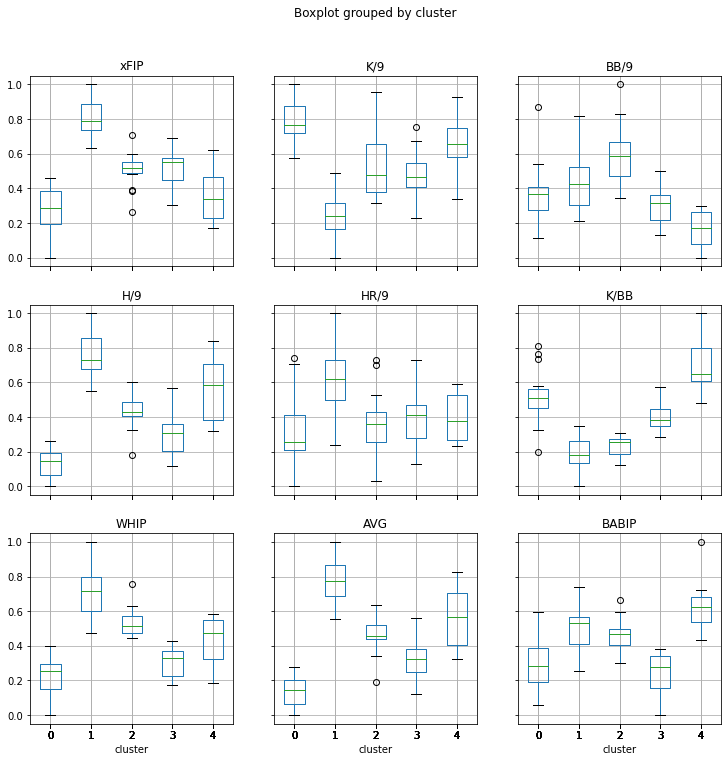

In [13]:
boxplot = scaled_performance_df.boxplot(column=['xFIP', 'K/9', 'BB/9', 'H/9', 'HR/9', 'K/BB', 'WHIP', 'AVG', 'BABIP'], by='cluster',
                     layout=(3, 3), figsize= (12,12))

### Evaluating the Clusters

![Alt text](image-1.png)

There are certain observations that we can make while comparing the statistics of pitchers belonging to different clusters. For example, we see that pitchers belonging to cluster 1 have a much higher: expected ERA, Hits per 9 innings and Walks Plus Hits per Innings Pitched as compared to the players in other clusters.

Interestingly, we notice that players belonging to cluster 4 have the lowest Walks per 9 innings. While this represents a high amount of discipline while pitching, we notice that these players also have high BABIP and Hits per 9 innings. Therefore, while pitchers in cluster 4 do not give away a lot of walks, we do notice that they are also hit more often.

Finally, Cluster 0 represents players who have the lowest Walks+Hits, AVG, Hits per 9 innings, Expected ERA and the highest strikeouts per 9 innings. This cluster therefore potentially represents some of the best-performing pitchers in the league that season. It is, therefore, not surprising to see pitchers such as Max Scherzer, Corbin Burnes, Zack Wheeler, and Robbie Ray in this list for 2021.

In [14]:
scaled_performance_df.loc["Alek Manoah"].cluster

3.0

Another potential application of this research could be to help identify potential players that the team could look into. For example, Alek Manoah has had a difficult season this year for the Blue Jays. Therefore, if the management is looking to replace him by signing a new player, they could look into pitchers who were in the same cluster as Manoah in 2021.

[Text(0.5, 1.0, "BABIP vs. H/9 for Alek Manoah's Cluster")]

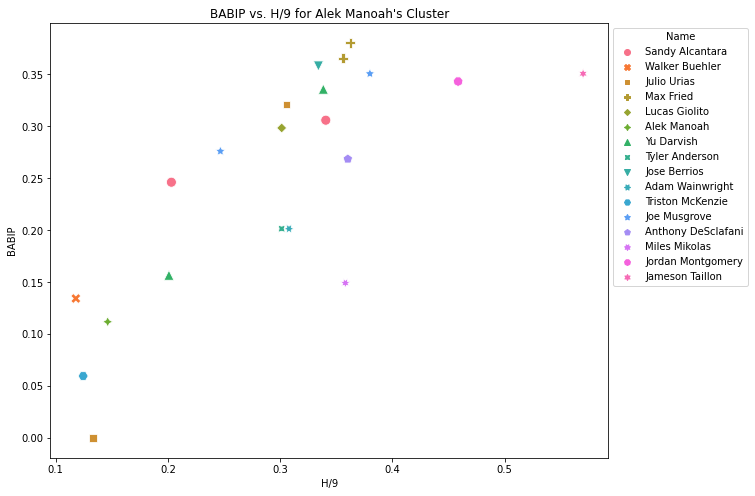

In [20]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x = "H/9", y = "BABIP", hue = scaled_performance_df.loc[scaled_performance_df.cluster == scaled_performance_df.loc["Alek Manoah"].cluster].index, style = scaled_performance_df.loc[scaled_performance_df.cluster == scaled_performance_df.loc["Alek Manoah"].cluster].index, data=scaled_performance_df.loc[scaled_performance_df.cluster == scaled_performance_df.loc["Alek Manoah"].cluster], s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title="BABIP vs. H/9 for Alek Manoah's Cluster")

![Alt text](image-2.png)

The graph above visualizes the pitchers belonging to Manoah's cluster based on their Hits per 9 innings and BABIP. From the graph, we see that Walker Buehler, Triston McKenzie and Julio Urias have similar performance to Manoah when it comes to the following metrics. An extended study can also be performed using more features to compare. This analysis can be a first step in helping the Blue Jays identify pitchers who can replace Manoah (based on similar performances during Manoah's previous seasons).

A similar visualization has been created below using the WHIP and BB/9.

[Text(0.5, 1.0, "WHIP vs. BB/9 for Alek Manoah's Cluster")]

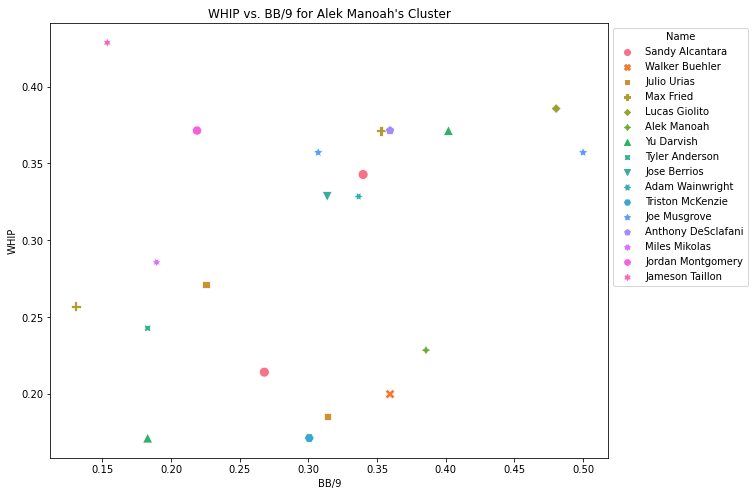

In [22]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x = "BB/9", y = "WHIP", hue = scaled_performance_df.loc[scaled_performance_df.cluster == scaled_performance_df.loc["Alek Manoah"].cluster].index, style = scaled_performance_df.loc[scaled_performance_df.cluster == scaled_performance_df.loc["Alek Manoah"].cluster].index, data=scaled_performance_df.loc[scaled_performance_df.cluster == scaled_performance_df.loc["Alek Manoah"].cluster], s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title="WHIP vs. BB/9 for Alek Manoah's Cluster")

# Cluster Analysis 2: Pitcher Style

Besides the performance, grouping the pitchers based on their pitching style could also be helpful. This kind of analysis could help differentiate pitchers who heavily rely on the fastball, from those that have a lot of variation in their pitching.

In [23]:
data_style = data_style.set_index("Name")
data_style.head()

,SL%,CT%,CB%,CH%,SF%,KN%,FB% 2,FBv,O-Swing%
Name,,,,,,,,,
Corbin Burnes,0.090,0.522,0.184,0.098,NaN,NaN,0.108,96.9,0.378
Zack Wheeler,0.249,NaN,0.107,0.032,0.004,NaN,0.607,97.1,0.352
Aaron Nola,NaN,0.065,0.265,0.145,NaN,NaN,0.524,92.6,0.370
Carlos Rodon,0.310,NaN,0.058,0.020,NaN,NaN,0.612,95.6,0.344
Justin Verlander,0.283,NaN,0.188,0.024,NaN,NaN,0.504,95.1,0.369


In [24]:
#Analyse the missing values in the dataset
data_style.loc[data_style.isnull().sum(1)>3]


,SL%,CT%,CB%,CH%,SF%,KN%,FB% 2,FBv,O-Swing%
Name,,,,,,,,,
Julio Urias,NaN,NaN,0.342,0.173,NaN,NaN,0.484,94.1,0.359
Logan Webb,0.327,NaN,NaN,0.310,NaN,NaN,0.363,91.9,0.345
Alek Manoah,0.271,NaN,NaN,0.109,NaN,NaN,0.620,93.6,0.347
Frankie Montas,0.193,NaN,NaN,NaN,0.224,NaN,0.583,96.3,0.359
Jose Berrios,NaN,NaN,0.305,0.132,NaN,NaN,0.563,94.0,0.340
Tyler Mahle,0.311,NaN,NaN,NaN,0.159,NaN,0.530,94.1,0.301
Luis Castillo,0.174,NaN,NaN,0.305,NaN,NaN,0.521,97.3,0.339
Triston McKenzie,0.220,NaN,0.219,NaN,NaN,NaN,0.561,92.5,0.359
Sean Manaea,0.156,NaN,NaN,0.242,NaN,NaN,0.602,92.2,0.325


Here we see that the missing NaN % simply represent 0% (sum of other pitch variations are ~ 1). Thus we can simply replace the missing values with 0.

In [25]:
data_style = data_style.fillna(0)

In [26]:
#Scale the features since we will be using a distance based algorithm
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_style)
scaled_style_df = pd.DataFrame(scaled_data, columns=data_style.columns, index=data_style.index)
scaled_style_df.head()

,SL%,CT%,CB%,CH%,SF%,KN%,FB% 2,FBv,O-Swing%
Name,,,,,,,,,
Corbin Burnes,0.209790,0.942238,0.484211,0.277620,0.000000,0.0,0.067395,0.905660,0.666667
Zack Wheeler,0.580420,0.000000,0.281579,0.090652,0.010929,0.0,0.976321,0.924528,0.489796
Aaron Nola,0.000000,0.117329,0.697368,0.410765,0.000000,0.0,0.825137,0.500000,0.612245
Carlos Rodon,0.722611,0.000000,0.152632,0.056657,0.000000,0.0,0.985428,0.783019,0.435374
Justin Verlander,0.659674,0.000000,0.494737,0.067989,0.000000,0.0,0.788707,0.735849,0.605442


### Identify the appropriate number of clusters

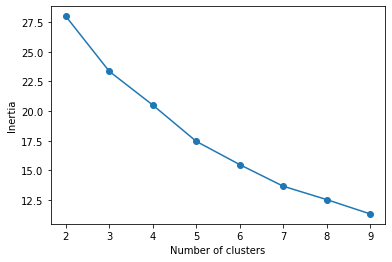

In [27]:
# Elbow Method:
inertia_score = []

for k in range(2, 10):
    model = KMeans(n_clusters = k, random_state = 0)
    model.fit(scaled_style_df)
    inertia_score.append(model.inertia_)

plt.plot(range(2,10), inertia_score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

We can use k=5 or 6 for our analysis.

### Create the clusters

In [35]:
# K means using 6 clusters
kmeans_style = KMeans(n_clusters = 6, init='k-means++', random_state=0)
kmeans_style.fit(scaled_style_df)
pred = kmeans_style.predict(scaled_style_df)

scaled_style_df['cluster'] = pred

In [36]:
scaled_style_df.cluster.value_counts()

0    28
2    15
5    14
4    13
3     9
1     5
Name: cluster, dtype: int64

In [37]:
scaled_style_df.head()

,SL%,CT%,CB%,CH%,SF%,KN%,FB% 2,FBv,O-Swing%,cluster
Name,,,,,,,,,,
Corbin Burnes,0.209790,0.942238,0.484211,0.277620,0.000000,0.0,0.067395,0.905660,0.666667,3
Zack Wheeler,0.580420,0.000000,0.281579,0.090652,0.010929,0.0,0.976321,0.924528,0.489796,0
Aaron Nola,0.000000,0.117329,0.697368,0.410765,0.000000,0.0,0.825137,0.500000,0.612245,2
Carlos Rodon,0.722611,0.000000,0.152632,0.056657,0.000000,0.0,0.985428,0.783019,0.435374,0
Justin Verlander,0.659674,0.000000,0.494737,0.067989,0.000000,0.0,0.788707,0.735849,0.605442,0


We will now evaluate the characteristics of these clusters to draw insights from them.

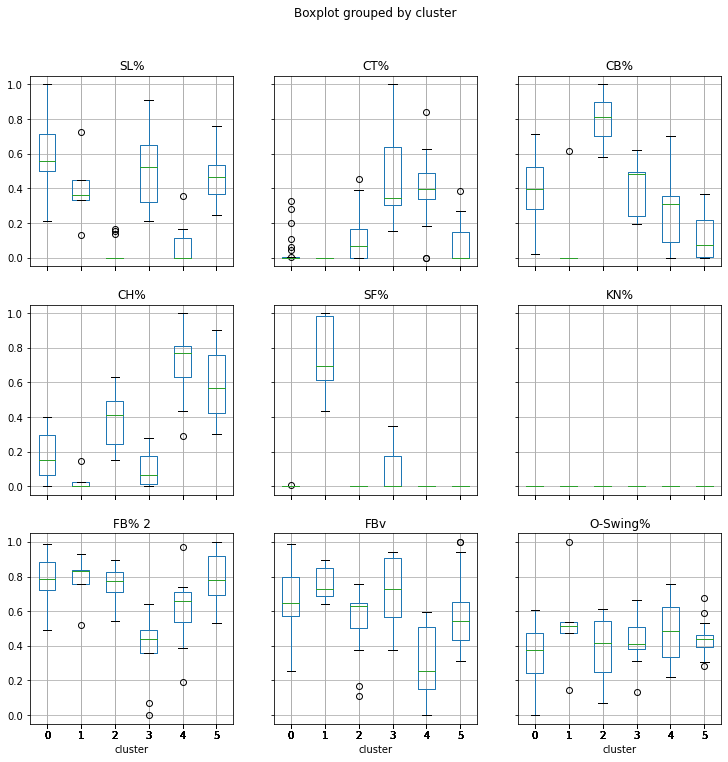

In [38]:
boxplot = scaled_style_df.boxplot(column=['SL%', 'CT%', 'CB%', 'CH%', 'SF%', 'KN%', 'FB% 2', 'FBv', 'O-Swing%'], by='cluster',
                     layout=(3, 3), figsize= (12,12))

### Evaluate the Clusters

![Alt text](image-4.png)

From the box plots above, we see that there is a clear distinction between the types of pitchers. For example, pitchers belonging to Cluster 2 throw a very high % of curveballs whereas pitchers in Cluster 1 throw a significantly higher percentage of split-finger pitchers. Interestingly, while cluster 3 does not have 1 dominating type of pitch, we see that they have a higher variation with relatively high average values for SL%, CT%, and CB%.

In [39]:
scaled_style_df.loc["Alek Manoah"].cluster

5.0

[Text(0.5, 1.0, "FB% vs. CT% for Alek Manoah's Cluster")]

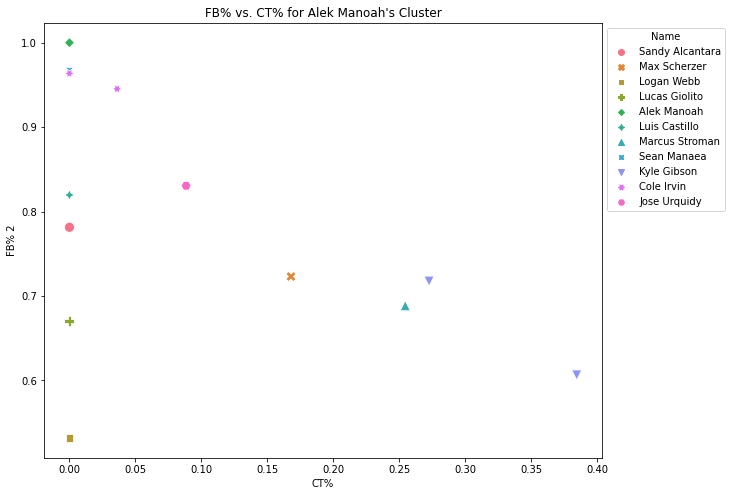

In [41]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x = "CT%", y = "FB% 2", hue = scaled_style_df.loc[scaled_style_df.cluster == scaled_style_df.loc["Alek Manoah"].cluster].index, style = scaled_style_df.loc[scaled_style_df.cluster == scaled_style_df.loc["Alek Manoah"].cluster].index, data=scaled_style_df.loc[scaled_style_df.cluster == scaled_style_df.loc["Alek Manoah"].cluster], s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title="FB% vs. CT% for Alek Manoah's Cluster")

Finally, we can perform a similar style-based cluster analysis for Alec Manoah. From the graph above, we see that if the Blue Jays were looking for similar pitchers to Manoah in terms of pitching style, Sean Manaea, Cole Irvin and Jose Urquindy have a similar high % of fastballs and very low % of cutters pitches.

The project above tries to cluster MLB pitchers into clusters based on their performance and pitching style in 2021. This kind of analysis could be used to help identify prospects whose performances in lower leagues could be similar to the more established pitchers. We also explored how the cluster analysis could be used by team management and scouts to identify new players with similar performance to existing pitchers, that could help them replace or provide backup for current pitchers. 